This is the code from the paper that was provided by the authors.

In [1]:
import os
import sys
import time
from scipy.io import loadmat
import gurobipy as gp
from gurobipy import GRB
import scipy.optimize as sci_opt
import matplotlib.pyplot as plt
import numpy as np
from sys import path
# TODO: Update the path to casadi
path.append(r'<casadi_path>')
import casadi as cas
import scipy

#
from jax import grad as j_grad
import jax.numpy as j_np
from IPython.display import display, Latex

# Load Data

In [2]:
# load the target's trajectory and sensors' positions and measurements
# TODO: Update the path to the trajectory
# OR
# TODO: Generate a trajectory
load_data = loadmat('<path of the trajectory dataset')

# number of timesteps
T = load_data['T'][0][0]

# number of agents (sensors)
N = load_data['N'][0][0]

# dimension of the target's state
n = load_data['n'][0][0]

# dimension of the agent's measurement per timestep
dim_meas = 2

# ground-truth trajectory of the target
X_true = load_data['X']

# sensors' positions
agents_pos = load_data['R']

# sensors' measurements
agents_meas = load_data['Y']

# range measurements
agents_range_meas = agents_meas[0::2, :]

# bearing measurements
agents_bear_meas = agents_meas[1::2, :]

# # composite measurements
# agents_meas = np.vstack((agents_range_meas,
#                          agents_bear_meas))

# sensors' heading angles
agents_head = load_data['agents_head']

agents_head = np.tile(agents_head, (T, 1))

# length of the target's wheelbase
L_base = 1.0

# Plot ground-truth trajectory

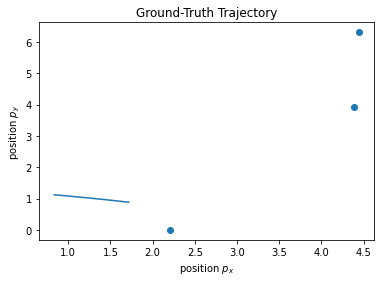

In [5]:
# ground-truth trajectory
X_true_rs = X_true.reshape((n, T), order='F')

fig = plt.figure()
ax = plt.gca()

# ground-truth trajectory
l_gt, = ax.plot(X_true_rs[0, :], X_true_rs[1, :])

# sensors
l_sn = ax.scatter(agents_pos[0, :], agents_pos[1, :])

# axis labels
ax.set_xlabel('position $p_{x}$')
ax.set_ylabel('position $p_{y}$')

title = ax.set_title('Ground-Truth Trajectory')

# Functions

In [59]:
# dynamics model
g_dyn = lambda x, dt: cas.vertcat(x[0, :] + dt * x[3, :] * cas.cos(x[2, :]),
                                 x[1, :] + dt * x[3, :] * cas.sin(x[2, :]),
                                 x[2, :] + dt * x[3, :] * cas.tan(x[4, :]) / L_base,
                                 x[3, :],
                                 x[4, :])

def g_dyn(x, dt):
    '''
        Dynamics Model
    '''
    
    if cas.__name__ in type(x).__module__:
        return cas.vertcat(x[0, :] + dt * x[3, :] * cas.cos(x[2, :]),
                           x[1, :] + dt * x[3, :] * cas.sin(x[2, :]),
                           x[2, :] + dt * x[3, :] * cas.tan(x[4, :]) / L_base,
                           x[3, :],
                           x[4, :])
        
#     elif type(x).__module__ == np.__name__:
    else:
        return j_np.vstack((x[0, :] + dt * x[3, :] * j_np.cos(x[2, :]),
                         x[1, :] + dt * x[3, :] * j_np.sin(x[2, :]),
                         x[2, :] + dt * x[3, :] * j_np.tan(x[4, :]) / L_base,
                         x[3, :],
                         x[4, :]))
    
# distributed variant
def g_dyn_dis(x, n_state, dt):
    '''
        Dynamics Model:
        Distributed Variant
    '''
    
    # output
    x_next = np.zeros(x.shape)
    
    # dynamics equation
    x_next[0::n_state, :] = x[0::n_state, :] + dt * x[3::n_state, :] * np.cos(x[2::n_state, :])
    x_next[1::n_state, :] = x[1::n_state, :] + dt * x[3::n_state, :] * np.sin(x[2::n_state, :])
    x_next[2::n_state, :] = x[2::n_state, :] + dt * x[3::n_state, :] * np.tan(x[4::n_state, :]) / L_base
    x_next[3::n_state, :] = x[3::n_state, :]
    x_next[4::n_state, :] = x[4::n_state, :]
    
    return x_next
        

# measurement model
h_dyn = lambda x, dt: cas.vertcat((np.sum((
    (agent_pos - x[0:2, :].flatten(order='F')[:, np.newaxis]) ** 2.0).reshape((2, -1), order='F'),
      axis=0).reshape((T, -1), order='F'),
      agents_head - x[2, :][:, np.newaxis]))

def h_meas(x):
    '''
        Measurement Model
    '''
    
    if cas.__name__ in type(x).__module__:
        # distance between each sensor and the target
        distance = ((agents_pos - x[0:2, :].reshape((-1, 1))) ** 2.0).reshape((2, -1))
        distance = cas.sum1(distance)

        # bearing measurements
        bearing = (agents_head - x[2:3, :].T).reshape((1, -1))

        # composite measurement
        meas = cas.vertcat(distance,
                           bearing)

        return meas.reshape((-1, N))
        
#     elif type(x).__module__ == np.__name__:
    else:
        # distance between each sensor and the target
        distance = ((agents_pos - x[0:2, :].reshape((-1, 1), order='F')) ** 2.0).reshape((2, -1), order='F')
        distance = np.sum(distance, axis=0)

        # bearing measurements
        bearing = (agents_head - x[2:3, :].T).reshape((1, -1), order='F')

        # composite measurement
        meas = j_np.vstack((distance,
                            bearing))

        return meas.reshape((-1, N), order='F')
    
    
# distributed variant
def h_meas_dis(x, n_state):
    '''
        Measurement Model:
        Distributed Variant
    '''
    # reshape states
    states = x.reshape((n_state, -1), order='F')
    
    # distance between each sensor and the target
    distance = ((agents_pos.reshape((2, -1), order='F') - states[0:2, :]) ** 2.0)
    distance = np.sum(distance, axis=0)

    # bearing measurements
    bearing = (agents_head.reshape((1, -1), order='F') - states[2:3, :])

    # composite measurement
    meas = np.vstack((distance,
                      bearing))
    
    return meas.reshape((-1, N), order='F')

# constraint function
cons_fn = lambda x, safe_dist: safe_dist ** 2.0 - np.sum((
    (agent_pos - x[0:2, :].flatten(order='F')[:, np.newaxis]) ** 2.0).reshape((2, -1), order='F'),
      axis=1).reshape((T, -1), order='F')

def constraint_fn(x, safe_dist, n_state):
    '''
        Constraint Function
    '''
    
    if cas.__name__ in type(x).__module__:
        # reshape the input
        x = x.reshape((n_state, -1))
        
        # distance between each sensor and the target
        distance = ((agents_pos - x[0:2, :].reshape((-1, 1))) ** 2.0).reshape((2, -1))
        distance = cas.sum1(distance)

        # constraint function
        constr = safe_dist ** 2.0 - distance.reshape((-1, N))

        return constr
        
#     elif type(x).__module__ == np.__name__:
    else:
        # reshape the input
        x_rs = x.reshape((n_state, -1), order='F')
    
        # shape of the original input
        in_shape = x.shape[1] if len(x.shape) > 1 else 1
        
        distance = ((agents_pos - x_rs[0:2, :].reshape((-1, in_shape), order='F')) ** 2.0)
        distance = j_np.sum(distance.reshape((2, -1), order='F'), axis=0)

        # constraint function
        constr = safe_dist ** 2.0 - distance.reshape((-1, N), order='F')

        return constr
    
# objective function
# objective_fn = lambda x, P_inv, Q_inv, L_inv: 
def objective_fn(x, P_t_inv, Q_inv, L_inv, mu, n_state, dt):
    '''
        Objective Function
    '''
    
    # reshape the input
    x = x.reshape((n_state, -1), order='F')
    
#     if type(x).__module__ == np.__name__:
    # dynamics component
    dyn_comp = x[:, 1:] - g_dyn(x, dt)[:, 0:-1]
    dyn_comp = j_np.sum(dyn_comp * (P_t_inv @ dyn_comp), axis=(0, 1))

    # measurements component
    meas_comp = agents_meas - h_meas(x)
    meas_comp = j_np.sum(meas_comp * (Q_inv @ meas_comp), axis=(0, 1))

    # prior distribution component
    prior_comp = x[:, 0] - mu
    prior_comp = prior_comp.T @ L_inv @ prior_comp

    # composite objective function
    objective = dyn_comp + meas_comp + prior_comp
        
    return objective

# Lagrangian function
def lagrangian_fn(x, v_mult, P_t_inv, Q_inv, L_inv, mu, n_state, dt):
    '''
        Lagrangian Function
    '''
    
    # Lagrangian function
    lagrangian = objective_fn(x, P_t_inv, Q_inv, L_inv, mu, n_state, dt) \
                + j_np.sum(v_mult * constraint_fn(x, safe_dist, n_state))
    
    return lagrangian
    

# dynamics model Jacobian
Jac_g = lambda x, dt: np.vstack((np.array([[1, 0, -dt * x[3] * np.sin(x[2]), dt * np.cos(x[2]), 0],
                                           [0, 1,  dt * x[3] * np.cos(x[2]), dt * np.sin(x[2]), 0],
                                           [0, 0,  1,                        (dt / L_base) * np.tan(x[4]),
                                                                 dt * (x[3] / L_base) / (np.cos(x[4]) ** 2.0)]]),
                                 np.array([[0, 0, 0, 1, 0],
                                           [0, 0, 0, 0, 1]])))

# measurement model Jacobian
Jac_h = lambda x, agent_pos: np.array([np.hstack((2 * (x[0:2] - agent_pos), [0, 0, 0])),
                                      [0, 0, -1, 0, 0]])

# Distributed Variants
def Jac_g_dis(x, n_state, dt):
    '''
        dynamics model Jacobian
    '''
    
    # reshape the input
    x = x.reshape((n_state, -1), order='F')
    
    # Jacobian
    J_g = np.broadcast_to(np.identity(n_state)[..., None], (n_state, n_state, x.shape[1])).copy()
    
    # Jacobian at each timestep
    J_g[0, 2, :] = -dt * x[3, :] * np.sin(x[2, :])
    J_g[0, 3, :] = dt * np.cos(x[2, :])
    J_g[1, 2, :] = dt * x[3, :] * np.cos(x[2, :])
    J_g[1, 3, :] = dt * np.sin(x[2, :])
    J_g[2, 3, :] = (dt / L_base) * np.tan(x[4, :])
    J_g[2, 4, :] = dt * (x[3, :] / L_base) / (np.cos(x[4, :]) ** 2.0)
    
    return J_g

# measurement model Jacobian
def Jac_h_dis(x, n_state):
    '''
        Measurement model Jacobian
    '''
    
    # reshape the input
    x = x.reshape((n_state, -1), order='F')
    
    # Jacobian
    J_h = np.broadcast_to(np.zeros((2, n_state))[..., None], (2, n_state, x.shape[1])).copy()
    
    # gradient for the distance measurement
    grad_distance = 2 * (x[0:2, :] - agents_pos.reshape((2, -1), order='F'))
    
    # Jacobian at each timestep
    J_h[0, 0, :] = grad_distance[0, :]
    J_h[0, 1, :] = grad_distance[1, :]
    J_h[1, 2, :] = -1
    
    return J_h

# gradient of the objective function
def gradient_objective(x, P_t_inv, Q_t_inv, L_inv, mu, n_state, dt):
    '''
        Gradient of the objective function
    '''
    
    # reshape the input
    x = x.reshape((n_state, -1), order='F')
    
    # dimension of states
    n_state = x.shape[0]
    
    # evaluation of the dynamics model
    dyn_eval = g_dyn(x, dt)
    
    # evaluation of the measurement model
    meas_eval = h_meas(x)
    
    # gradient
    grad = []
    
    for tm in range(T):
        # preceeding dynamics components
        dync_comp_prec = np.zeros((n_state,))
        
        # succeeding dynamics components
        dync_comp_succ = np.zeros((n_state,))
        
        if tm < T - 1:
            # preceeding dynamics components
            dync_comp_prec = 2 * Jac_g(x[:, tm], dt).T @ P_t_inv @ (dyn_eval[:, tm] - x[:, tm + 1])
            
        if tm > 0:
            # succeeding dynamics components
            dync_comp_succ = 2 * P_t_inv @ (x[:, tm] - dyn_eval[:, tm - 1])
            
        # measurement components
        meas_comp = np.zeros((n_state,))

        for agent in range(N):
            meas_comp += 2 * Jac_h(x[:, tm], agents_pos[2 * tm : 2 * (tm + 1), agent]).T \
                         @ Q_t_inv @ (meas_eval[2 * tm : 2 * (tm + 1), agent] - 
                                    agents_meas[2 * tm : 2 * (tm + 1), agent])
         
        # prior component
        prior_comp = np.zeros((n_state,))
        
        if tm == 0:
            prior_comp = 2 * L_inv @ (x[:, 0] - mu)
        
        # composition of the components
        grad.append(dync_comp_prec + dync_comp_succ + meas_comp + prior_comp)
        
    # gradient
    grad = np.hstack(grad)
    
    return grad
    
# gradient of the constraint function
def gradient_constraint(x, n_state):
    '''
        Gradient of the constraint function
    '''
    
    # reshape the input
    x_rs = x.reshape((n_state, -1), order='F')
    
    # shape of the original input
    in_shape = x.shape[1] if len(x.shape) > 1 else 1
     
    # gradient
    grad = -2 * (x_rs[0:2, :].reshape((-1, in_shape), order='F') - agents_pos)
    
    return grad

# gradient of the Lagrangian
def gradient_lagrangian(x, v_mult, P_t_inv, Q_t_inv, L_inv, mu, n_state, dt):
    '''
        Gradient of the Lagrangian function
    '''
    
    # gradient of the objective function
    grad_objective = gradient_objective(x, P_t_inv, Q_t_inv, L_inv, mu, n_state, dt)
    
    # gradient of the constraint function
    grad_constraint = gradient_constraint(x, n_state)
    
    # gradient of the relaxed constraint term in the Lagrangian
    grad_rel_cn = grad_constraint * np.repeat(v_mult, repeats=2, axis=0)
    
    # zero gradient for non-position-related states
    grad_rel_cn = np.sum(grad_rel_cn, axis=1).reshape((2, -1), order='F')
    grad_rel_cn = np.vstack((grad_rel_cn,
                             np.zeros((3, grad_rel_cn.shape[1]))))
    
    # gradient of the Lagrangian function
    grad_lag = grad_objective + grad_rel_cn.reshape((-1,), order='F')
    
    return grad_lag

# gradient of the Lagrangian function via JAX
grad_lag_jax = j_grad(lagrangian_fn)

# approximation of the Hessian
def BFGS_update(x_prev, x_curr, v_mult, H_prev, P_t_inv, Q_inv, L_inv, mu, n_state, dt):
    '''
        BFGS Approximation of the Hessian of the Lagrangian
    '''

    # update step
    step = (x_curr - x_prev)
    
    # update in gradient of the Lagrangian
#     y_g = gradient_lagrangian(x_curr, v_mult, P_inv, Q_t_inv, L_inv, mu, dt) \
#         - gradient_lagrangian(x_prev, v_mult, P_inv, Q_t_inv, L_inv, mu, dt)
    
    y_g = grad_lag_jax(x_curr, v_mult, P_t_inv, Q_inv, L_inv, mu, n_state, dt) \
        - grad_lag_jax(x_prev, v_mult, P_t_inv, Q_inv, L_inv, mu, n_state, dt)
    
    # Hessian-vector product
    H_s_prod = H_prev @ step

    # computation time
    start_time_BFGS = time.perf_counter()
    
    # updated Hessian
    H_curr = H_prev - (H_s_prod @ step.T @ H_prev) / (step.T @ H_s_prod) + (y_g @ y_g.T) / (y_g.T @ step)
    
    # computation time update equation
    time_req_update = time.perf_counter() - start_time_BFGS
    
    if (y_g.T @ step) < 0:
        display(Latex('Warning! $y^{T}s$ is not positive. The Hessian might not be positive definite.'))
        
    # computation time
    start_time_eigs = time.perf_counter()
    
    # eigenvalues
#     eig_vals = np.linalg.eigvals(H_curr)

    
#     min_eig_val = scipy.linalg.eigh(H_curr, eigvals_only=True, 
#                                     subset_by_index=[H_curr.shape[-1] - 1, H_curr.shape[-1] - 1])
    
    min_eig_val = scipy.sparse.linalg.eigsh(scipy.sparse.bsr_array(H_curr), return_eigenvectors=False,
                                            which='SM', k=1)
    
    # computation time eigenvalues
    time_req_eigs = time.perf_counter() - start_time_eigs
    
#     min_eig_val = np.amin(eig_vals)
    
    buffer = 1e-2
    
    if min_eig_val < 1e-5:
        print('The Hessian is not be positive definite! Conditioning the Hessian')
        
        # computation time
        start_time_cond = time.perf_counter()
    
        # project to the set of positive definite matrices
        H_curr = H_curr + (np.abs(min_eig_val) + buffer) * np.eye(*H_curr.shape)
            
        # computation time update equation
        time_req_cond = time.perf_counter() - start_time_cond
    
        eig_vals = np.linalg.eigvals(H_curr)
        min_eig_val = np.amin(eig_vals)

        print(f'min eigs {min_eig_val}')
        print(f'Cond computation time: {time_req_cond}')
        
        
    # print total computation time
    print(f'Update computation time: {time_req_update}')
    print(f'Eigs computation time: {time_req_eigs}')
    
    return np.asarray(H_curr)

# # #
# # # Distributed Variants
# # #

# gradient of the objective function
def gradient_objective_dis(x, P_inv, Q_inv, L_inv, mu, n_state, dt):
    '''
        Gradient of the objective function
    '''
    
    # evaluation of the dynamics model
    dyn_eval = g_dyn_dis(x, n_state, dt)
    
    # evaluation of the measurement model
    meas_eval = h_meas_dis(x, n_state)
    
    # Jacobian for the dynamics model
    Jac_dyn = Jac_g_dis(x, n_state, dt)
    
    # Jacobian for the measurement model
    Jac_meas = Jac_h_dis(x, n_state)
    
    # block-diagonal dynamics Jacobian
    Jac_dyn_blk = scipy.sparse.block_diag([np.squeeze(arr) for arr in np.split(Jac_dyn,
                                                                               Jac_dyn.shape[2],
                                                                               axis=2)])
    
    # block-diagonal measurement Jacobian
    Jac_meas_blk = scipy.sparse.block_diag([np.squeeze(arr) for arr in np.split(Jac_meas,
                                                                                Jac_meas.shape[2],
                                                                                axis=2)])

    # dynamics components temporary variable
    dync_comp_buff = np.zeros(x.shape)
    
    # preceeding dynamics components
    dync_comp_buff[:-n_state, :] = dyn_eval[:-n_state, :] - x[n_state:, :]
    dync_comp_prec = 2 * (Jac_dyn_blk.T @ (P_inv @ dync_comp_buff).ravel(order='F'))
            
    # succeeding dynamics components
    dync_comp_buff[n_state:, :] = x[n_state:, :] - dyn_eval[:-n_state, :]
    dync_comp_buff[:n_state, :] = 0
    dync_comp_succ = 2 * P_inv @ dync_comp_buff
    
    # measurement components
    meas_comp = 2 * (Jac_meas_blk.T @ (Q_inv @ (meas_eval - agents_meas)).ravel(order='F'))
    
    # prior component
    prior_comp = 2 * L_inv @ (x[:n_state, :] - mu)
    
    # gradient of the objective function
    grad = (1 / N) * (dync_comp_prec.reshape((-1, N), order='F') + dync_comp_succ) \
           + meas_comp.reshape((-1, N), order='F')
    
    # incorporate the prior term
    grad[:n_state, :] += (1 / N) * prior_comp
    
    return grad

# gradient of the Lagrangian
def gradient_lagrangian_dis(x, v_mult, P_inv, Q_inv, L_inv, mu, n_state, dt):
    '''
        Gradient of the Lagrangian function
    '''
    
    # gradient of the objective function
    grad_objective = gradient_objective_dis(x, P_inv, Q_inv, L_inv, mu, n_state, dt)
    
    # gradient of the constraint function
    grad_constraint = gradient_constraint(x, n_state)
    
    # gradient of the relaxed constraint term in the Lagrangian
    grad_rel_cn = grad_constraint * np.repeat(v_mult, repeats=2, axis=0)
    
    # zero gradient for non-position-related states
    grad_rel_cn = grad_rel_cn.reshape((2, -1), order='F')
    grad_rel_cn = np.vstack((grad_rel_cn,
                             np.zeros((3, grad_rel_cn.shape[1]))))
    
    # gradient of the Lagrangian function
    grad_lag = grad_objective + grad_rel_cn.reshape((-1, N), order='F')
    
    return grad_lag

# approximation of the Hessian
def BFGS_update_dis(x_prev, x_curr, v_mult, H_prev, P_inv, Q_inv, L_inv, mu, n_state, dt):
    '''
        BFGS Approximation of the Hessian of the Lagrangian
    '''

    # update step
    step = (x_curr - x_prev)
    
    # update in gradient of the Lagrangian
    y_g = gradient_lagrangian_dis(x_curr, v_mult, P_inv, Q_inv, L_inv, mu, n_state, dt) \
        - gradient_lagrangian_dis(x_prev, v_mult, P_inv, Q_inv, L_inv, mu, n_state, dt)

    # updated Hessian
    H_curr = []
    
    for agent in range(N):
        # previous Hessian
        H_prev_dis = H_prev[agent]
        
        # update step
        step_dis = step[:, agent:agent + 1]
    
        # update in gradient of the Lagrangian
        y_g_dis = y_g[:, agent:agent + 1]
        
        # Hessian-vector product
        H_s_prod = H_prev_dis @ step_dis

        # updated Hessian
        H_curr_dis = H_prev_dis - (H_s_prod @ step_dis.T @ H_prev_dis) \
                     / (step_dis.T @ H_s_prod) + (y_g_dis @ y_g_dis.T) \
                     / (y_g_dis.T @ step_dis)
        

        if (y_g_dis.T @ step_dis) < 0:
            print(f'Agent {agent}: BFGS Update')
            display(Latex('Warning! $y^{T}s$ is not positive. The Hessian might not be positive definite.'))

        # eigenvalues
        eig_vals = np.linalg.eigvals(H_curr_dis)
        min_eig_val = np.amin(eig_vals)

        buffer = 1e-2

        if min_eig_val < 1e-5:
            print('The Hessian is not positive definite! Conditioning the Hessian')

            # project to the set of positive definite matrices
            H_curr_dis = H_curr_dis + (np.abs(min_eig_val) + buffer) * np.eye(*H_curr_dis.shape)
            
#             eig_vals = np.linalg.eigvals(H_curr_dis)
#             min_eig_val = np.amin(eig_vals)
            
#             print(f'min eigs {min_eig_val}')
            
        H_curr.append(H_curr_dis)

    return H_curr
          
          

In [55]:
# evaluation
# query vector
X_eval = init_sol.reshape((-1,), order='F')

# gradient of the objective
grad_obj_jax = j_grad(objective_fn)

X_eval_dis = np.broadcast_to(X_eval[:, np.newaxis], (tot_n_var, N))
mu_prior_dis = np.broadcast_to(mu_prior[:, np.newaxis], (n_state, N))

# Gradient of the Objective Function

grad_obj_jval = grad_obj_jax(X_eval, P_t_inv, Q_inv.toarray(), L_inv.toarray(), mu_prior, n_state, dt)

grad_obj_anal = gradient_objective(X_eval, P_t_inv, Q_inv_tstep, L_inv, mu_prior, n_state, dt)

grad_obj_anal_dis = gradient_objective_dis(X_eval_dis, P_inv, Q_inv, L_inv, mu_prior_dis, n_state, dt)

# gradient of the Lagrangian function
grad_lag_jax = j_grad(lagrangian_fn)

grad_lag_jval = grad_lag_jax(X_eval, v_mult_ncp, P_t_inv, Q_inv.toarray(), L_inv.toarray(), mu_prior, n_state, dt)

grad_lag_anal = gradient_lagrangian(X_eval, v_mult_ncp, P_t_inv, Q_inv_tstep, L_inv, mu_prior, n_state, dt)

grad_lag_anal_dis = gradient_lagrangian_dis(X_eval_dis, v_mult_ncp,
                                            P_inv, Q_inv, L_inv,
                                            mu_prior_dis, n_state, dt)

diff_g_lag = np.linalg.norm(grad_lag_jval - grad_lag_anal)
diff_g_lag_dis = np.linalg.norm(grad_lag_anal - np.sum(grad_lag_anal_dis, axis=1))

diff_g_obj = np.linalg.norm(grad_obj_jval - grad_obj_anal)
diff_g_obj_dis = np.linalg.norm(grad_obj_anal - np.sum(grad_obj_anal_dis, axis=1))

sep = '-' * 50

print(f'norm diff. grad. lag.: {diff_g_lag}')
print(f'norm diff. grad. obj.: {diff_g_obj}')
print(f'norm diff. grad. lag. dis.: {diff_g_obj_dis}')
print(f'norm diff. grad. obj. dis.: {diff_g_obj_dis}')
print(sep)
print(f'max grad. obj. adiff.: {np.amax(np.abs(grad_obj_jval))}')
print(f'max grad. obj. analy.: {np.amax(np.abs(grad_obj_anal))}')

norm diff. grad. lag.: 4.99910447615548e-06
norm diff. grad. obj.: 4.99910447615548e-06
norm diff. grad. lag. dis.: 2.5696495740433956e-06
norm diff. grad. obj. dis.: 2.5696495740433956e-06
--------------------------------------------------
max grad. obj. adiff.: 2.070464611053467
max grad. obj. analy.: 2.070464611053467


In [ ]:
%timeit for _ in range(100): grad_lag_jax(X_eval, v_mult_ncp, P_inv, Q_inv, L_inv, mu_prior, dt)

In [ ]:
%timeit for _ in range(100): gradient_lagrangian(X_eval, v_mult_ncp, P_inv, Q_inv_tstep, L_inv, mu_prior, dt)

In [ ]:
from jax import jacfwd, jacrev

hess_lag_jax = jacfwd(jacrev(lagrangian_fn))

X_e = init_sol.reshape((-1,), order='F')

X_e = np.vstack((X_true[0:3, :], np.zeros((2, T)))).reshape((-1,), order='F')

hess_lag_jval = hess_lag_jax(X_e, v_mult_ncp, P_t_inv, Q_inv.toarray(), L_inv.toarray(), mu_prior, n_state, dt)

print(f'hess_shape: {hess_lag_jval.shape}')

print(f'min. eigval. of hess: {np.amin(np.linalg.eigvals(hess_lag_jval))}')

In [ ]:
hess_app_dis = [hess_app for _ in range(N)]
x_prev_dis = np.broadcast_to(x_prev, (tot_n_var, N))
x_curr_dis = np.broadcast_to(x_curr, (tot_n_var, N))

BFGS_update_dis(x_prev_dis, x_curr_dis, v_mult_ncp, hess_app_dis, P_inv, Q_inv, L_inv, mu_prior_dis, n_state, dt)

# Problem Parameters

In [7]:
# timestep
dt = 7e-2

# dimension of the target's state
n_targ_state = 3

# size of augmentation (control inputs)
n_aug = 2

# size of the augmented state
n_state = n_targ_state + n_aug

# number of variables
n_var = (n_state,  int(T)) #T.item())

# total number of variables
tot_n_var = np.prod(n_var)

# number of constraints
n_cons = N * T

# safety distance
safe_dist = np.amin(np.sqrt(agents_range_meas))

# covariance matrices
# process noise
p_scale = 1.1e-4
p_s = np.random.default_rng().normal(0.0, 1.0, (n_state, n_state))
P_t_inv = p_scale * (p_s @ p_s.T) + 1e-2 * np.eye(n_state, n_state)
P_inv = scipy.sparse.csr_array(np.kron(np.eye(T, T), P_t_inv))
# dense format
P_inv_dense = P_inv.toarray()

# measurement noise
q_scale = 2.1e-3
q_s = np.random.default_rng().normal(0.0, 1.0, (dim_meas, dim_meas))
Q_inv_tstep = q_scale * (q_s @ q_s.T) + 1e-2 * np.eye(dim_meas, dim_meas)
Q_inv = scipy.sparse.csr_array(np.kron(np.eye(T, T), Q_inv_tstep))
# dense format
Q_inv_dense = Q_inv.toarray()

# Prior distribution of the target's trajectory
# mean
mu_prior = np.hstack((X_true[0:n_targ_state, 0], np.zeros((n_aug,)))) \
           + np.random.default_rng().normal(0.0, 1.0, (n_state,))

# covariance
l_scale = 0.1e-3
l_s = np.random.default_rng().normal(0.0, 1.0, (n_state, n_state))
L_inv = l_scale * (l_s @ l_s.T) + 1e-2 * np.eye(n_state, n_state)
L_inv = scipy.sparse.csr_array(L_inv)
# dense format
L_inv_dense = L_inv.toarray()
 

# # Hessian
# H = np.eye(n_var, n_var) + np.diag(np.random.random((n_var,)))

# # objective vector
# g = np.random.random((n_var,))

# # constraint matrix
# A = np.random.random((n_cons, n_var))

# constraint vector
lbA = -1 * np.random.random((n_cons, ))
ubA = np.random.random((n_cons, ))

# variable bounds
lb = -np.inf * np.ones(n_var)
ub = np.inf * np.ones(n_var)

# initial solution
std_init_sol = 1e-1
init_sol = np.vstack((X_true[0:3, :], np.zeros((2, T)))) \
            + std_init_sol * np.random.default_rng().normal(0.0, 1.0, (n_state, T))

# Non-Convex Problem

In [ ]:
# optimization variables
X = cas.SX.sym('trajectory', n_var)

# all variables
var = X

# objective function
# dynamics component
ncp_dyn_comp = X[:, 1:] - g_dyn(var, dt)[:, 0:-1]
ncp_dyn_comp = cas.sum2(cas.sum1(ncp_dyn_comp * (P_t_inv @ ncp_dyn_comp)))

# measurements component
ncp_meas_comp = agents_meas - h_meas(X)
ncp_meas_comp = cas.sum2(cas.sum1(ncp_meas_comp * (Q_inv_dense @ ncp_meas_comp)))

# prior distribution component
ncp_prior_comp = X[:, 0] - mu_prior
ncp_prior_comp = ncp_prior_comp.T @ L_inv.toarray() @ ncp_prior_comp

# composite objective function
ncp_objective = ncp_dyn_comp + ncp_meas_comp + ncp_prior_comp

# constraint function
opt_cons = constraint_fn(X, safe_dist, n_state)
opt_cons = opt_cons.reshape((opt_cons.numel(), 1))

# constraint bounds
cons_lb = -np.inf * np.ones((opt_cons.numel(), 1))
cons_ub = np.zeros((opt_cons.numel(), 1))

# variable bounds
var_lb = -np.inf * np.ones((var.numel(), 1))
var_ub = np.inf * np.ones((var.numel(), 1))

# reshape variable
var = var.reshape((var.numel(), 1))

# solver options
solver_options = {'print_time': True}

# IPOPT options
solver_options['ipopt'] = {'linear_solver': 'ma57',
                           'print_level': 5,
                           'obj_scaling_factor': 1e0}

# initial solution
var_init = init_sol.reshape((init_sol.size, 1), order='F')

# solve the problem
# problem
problem = {'x': var,
           'f': ncp_objective,
           'g': opt_cons}

# intialize solver
solver = cas.nlpsol('solver', 'ipopt', problem, solver_options)


# computation time
start_time = time.perf_counter()

# solution
result = solver(x0=var_init,
                lbx=var_lb,
                ubx=var_ub,
                lbg=cons_lb,
                ubg=cons_ub)

ncp_solution = result['x'].full()

# computaton time
time_req =  (time.perf_counter() - start_time) 

# print total computation time
print(f'\nTotal computation time: {time_req}')

# Lagrange multipliers
v_mult_ncp = result['lam_g'].reshape((-1, N)).full()

# objective function value
print(f"\n\nObjective function value: {result['f']}")

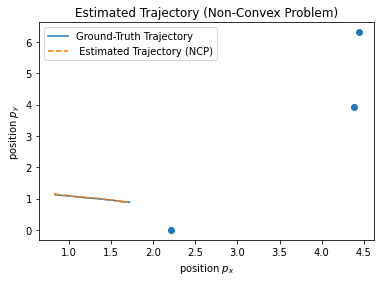

In [9]:
# plot estimated trajectory
X_ncp = ncp_solution.reshape((n_state, T), order='F')

fig = plt.figure()
ax = plt.gca()

# ground-truth trajectory
l_gt, = ax.plot(X_true[0, :], X_true[1, :])

# estimated trajectory
l_ncp, = ax.plot(X_ncp[0, :], X_ncp[1, :], '--')

# sensors
l_sn = ax.scatter(agents_pos[0, :], agents_pos[1, :])

# axis labels
ax.set_xlabel('position $p_{x}$')
ax.set_ylabel('position $p_{y}$')

# legend
ax.legend([l_gt, l_ncp], ['Ground-Truth Trajectory',
                          'Estimated Trajectory (NCP)'])

title = ax.set_title('Estimated Trajectory (Non-Convex Problem)')

In [ ]:
x_prev = init_sol.ravel(order='F')[:, None]
x_curr = X_ncp.ravel(order='F')[:, None]
r_app = np.random.default_rng().random((tot_n_var, 1))
hess_app = r_app @ r_app.T + 1e1 * np.eye(tot_n_var, tot_n_var)

BFGS_update(x_prev, x_curr, v_mult_ncp, hess_app, P_t_inv, Q_inv_dense, L_inv_dense, mu_prior, n_state, dt)

# SQP

In [11]:
# number of iterations
n_iter = 50

# initial solution
sqp_init = init_sol

# initial approximation of the Hessian of the Lagrangian
# hess_app = 1e2 * np.eye(tot_n_var, tot_n_var)

# iterates
X_sqp = np.zeros((*n_var, n_iter + 1))
X_sqp[:, :, 0] = sqp_init

## Optimization Setup

In [14]:
# optimization variables
X = cas.SX.sym('trajectory', tot_n_var, 1)

# all variables
var = X

# reshape variable
var = var.reshape((var.numel(), 1))

# constraint bounds
cons_lb = -np.inf * np.ones((n_cons, 1))
cons_ub = np.zeros((n_cons, 1))

# variable bounds
var_lb = -np.inf * np.ones((var.numel(), 1))
var_ub = np.inf * np.ones((var.numel(), 1))

# solver options
solver_options = {'print_time': False}

# IPOPT options
solver_options['ipopt'] = {'linear_solver': 'ma57',
                           'print_level': 0,
                           'obj_scaling_factor': 1e-7}

In [ ]:
# counter for the iterate
iter_cn = 0

# compute relevant quantities at the current iterate
X_curr = X_sqp[:, :, iter_cn].ravel(order='F')[:, np.newaxis]

# initial approximation of the Hessian of the Lagrangian
hess_app = 1e1 * np.eye(tot_n_var, tot_n_var)

# # alternative
# r_app = np.random.default_rng().random((tot_n_var, 1))
# hess_app = r_app @ r_app.T + 1e1 * np.eye(tot_n_var, tot_n_var)

# gradient of the objective
grad_obj_jax = j_grad(objective_fn)

# line separator
sep = '-' * 50

# computation time
start_time_loop = time.perf_counter()

# computaton time
time_req_solver = 0
time_req_BFGS = 0

for iter_n in range(n_iter):
    # gradient of the objective function
    grad_f = np.asarray(grad_obj_jax(X_curr,
                                     P_t_inv, Q_inv_dense, L_inv_dense,
                                     mu_prior, n_state, dt))

    # gradient of the constraint function
    grad_phi = gradient_constraint(X_curr, n_state)

    # update step
    step = (X - X_curr)

    # SQP objective function
    sqp_objective = grad_f.T @ X + 0.5 * step.T @ hess_app @ step

    # SQP constraint function
    # linearized components depending on the gradient
    lin_comp = grad_phi * (X - X_curr).reshape((n_state, T))[0:2, :].reshape((-1, 1))
                                                                                        
                                                                                        
    lin_comp = cas.sum1(lin_comp.reshape((2, -1))).reshape((-1, N))

    # SQP constraint function
    sqp_cons = np.asarray(constraint_fn(X_curr, safe_dist, n_state)) + lin_comp
    sqp_cons = sqp_cons.reshape((-1, 1))

#     sqp_cons = np.zeros((n_cons, 1))

    # initial solution
    var_init = X_curr

    # solve the problem
    # problem
    problem = {'x': var,
               'f': sqp_objective,
               'g': sqp_cons}

    # intialize solver
    solver = cas.nlpsol('solver', 'ipopt', problem, solver_options)

    # computation time
    start_time_solver = time.perf_counter()

    # solution
    result = solver(x0=var_init,
                    lbx=var_lb,
                    ubx=var_ub,
                    lbg=cons_lb,
                    ubg=cons_ub)
    
    # computation time
    time_req_solver += (time.perf_counter() - start_time_solver)

    sqp_solution = result['x'].full()

    # Lagrange multiplier
    v_mult_sqp = result['lam_g'].reshape((-1, N)).full()

    # previous iterate
    X_prev = X_curr

    # current iterate
    X_curr = sqp_solution

    # save the current iterate
    X_sqp[:, :, iter_cn + 1] = sqp_solution.reshape((n_state, T), order='F')

    # advance the iteration counter
    iter_cn += 1

    # computation time
    start_time_BFGS = time.perf_counter()

    # update the approximation of the Hessian
    hess_app = BFGS_update(X_prev, X_curr, v_mult_sqp, hess_app,
                           P_t_inv, Q_inv_dense, L_inv_dense, mu_prior, n_state, dt)
    
#     hess_app = hess_lag_jax(X_curr, v_mult_sqp, P_inv, Q_inv, L_inv, mu_prior, dt)
#     hess_app = np.asarray(hess_app)
    
    # computation time
    time_req_BFGS += (time.perf_counter() - start_time_BFGS)
    

    print(sep)
    print(f'Iteration {iter_n}')

    # objective function value
    print(f"\nObjective function value: {result['f']}")
    
    print(f'hess: {np.amin(np.linalg.eigvals(hess_app))}')
    
    # solver stats
    solver_stats = solver.stats()
    
    if not solver_stats['success']:
        print('The Solver failed to find a solution.')
         
        # failure report
        print(f"Solver Status: {solver_stats['return_status']}.")

        print(sep)
        
        break

    print(sep)

# computaton time
time_req_loop =  (time.perf_counter() - start_time_loop) 

# print total computation time
print(f'Total computation time: {time_req_loop}')
print(f'Solver computation time: {time_req_solver}')
print(f'BFGS computation time: {time_req_BFGS}')

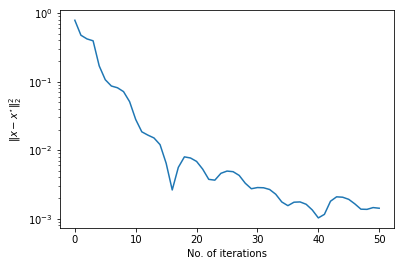

In [20]:
# convergence error
conv_error = np.zeros((n_iter + 1,))

X_sqp_vec = X_sqp[:n_targ_state,...].reshape((-1, n_iter + 1), order='F')
X_ncp_vec = X_ncp[:n_targ_state].reshape((-1, 1), order='F')

# l2-norm
conv_error = np.sum((X_sqp_vec - X_ncp_vec) ** 2.0, axis=0)

# plot convergence error
iter_plot = range(0, n_iter + 1)

fig = plt.figure()

ax = plt.gca()

ln_cv, = ax.plot(iter_plot, conv_error)

# axis labels
ax.set_xlabel('No. of iterations')
ax.set_ylabel('$\Vert x - x^{\star}\Vert_{2}^{2}$')

ax.set_yscale('log')

plt.show()

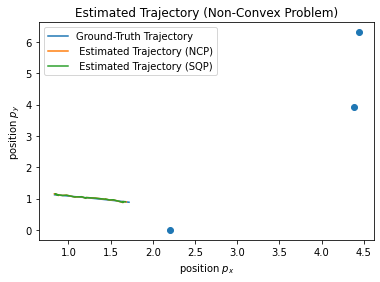

In [122]:
# plot estimated trajectory
fig = plt.figure()
ax = plt.gca()

# ground-truth trajectory
l_gt, = ax.plot(X_true[0, :], X_true[1, :])

# estimated trajectory via non-convex problem
l_ncp, = ax.plot(X_ncp[0, :], X_ncp[1, :])

# estimated trajectory via SQP
l_sqp, = ax.plot(X_sqp[0, :, -1], X_sqp[1, :, -1])

# sensors
l_sn = ax.scatter(agents_pos[0, :], agents_pos[1, :])

# axis labels
ax.set_xlabel('position $p_{x}$')
ax.set_ylabel('position $p_{y}$')

# legend
legend_label = ['Ground-Truth Trajectory',
                ' Estimated Trajectory (NCP)',
                ' Estimated Trajectory (SQP)']

ax.legend([l_gt, l_ncp, l_sqp], legend_label)

title = ax.set_title('Estimated Trajectory (Non-Convex Problem)')

# Distributed Algorithms

In [123]:
# communication network

# fully-connected
graph = {}

# unsigned Laplacian
graph['unsigned_Lp'] = np.ones((N, N))
np.fill_diagonal(graph['unsigned_Lp'], N - 1)

# signed Laplacian
graph['signed_Lp'] = -np.ones((N, N))
np.fill_diagonal(graph['signed_Lp'], N - 1)

# SquATT Algorithm

In [148]:
# number of SQP iterations
n_iter_sqp = 10

# number of ADMM iterations
n_iter_admm = 10

# total number of iterations
tot_n_iter = n_iter_sqp * n_iter_admm

# optimization penalty
rho = 1.5e1

# initial solution
d_alg_init = init_sol

# initial state trajectory
mu_prior_dis = np.broadcast_to(mu_prior[:, None], (n_state, N))

# initial approximation of the Hessian of the Lagrangian
# hess_app = 1e2 * np.eye(tot_n_var, tot_n_var)

# iterates for variables
sol_var = {}

# primal solutions
sol_var['X'] = np.random.random((tot_n_var, N, tot_n_iter + 1))

# initial solution
sol_var['X'][:, :, 0] = np.tile(init_sol.ravel(order='F')[:, np.newaxis], (1, N))

# Lagrange Multipliers for consensus constraints
sol_var['V'] = np.zeros((tot_n_var, N, tot_n_iter + 1))

# relative convergence error
converge_error = {}
converge_error['X'] = np.zeros((tot_n_iter + 1,))

In [149]:
# optimization variables
X = cas.SX.sym('trajectory', tot_n_var, N)

# all variables
var = X

# constraint bounds
cons_lb = -np.inf * np.ones((T, N))
cons_ub = np.zeros((T, N))

# variable bounds
var_lb = -np.inf * np.ones(X.shape)
var_ub = np.inf * np.ones(X.shape)

# solver options
solver_options = {'print_time': False}

# IPOPT options
solver_options['ipopt'] = {'linear_solver': 'ma57',
                           'print_level': 0,
                           'obj_scaling_factor': 1e-7}

In [ ]:
# counter for the iterate
iter_cn = 0

# compute relevant quantities at the current iterate
X_curr = sol_var['X'][:, :, iter_cn]

# initial solution
sqp_solution = np.zeros(X_curr.shape)

# initial Lagrange multiplier for local constraints
v_mult_sqp_dis = np.zeros((T, N))

# initial approximation of the Hessian of the Lagrangian
hess_app = [1e0 * np.eye(tot_n_var, tot_n_var) for _ in range(N)]

# alternative
# r_app = np.random.default_rng().random((tot_n_var, 1))
# hess_app = r_app @ r_app.T + 1e4 * np.eye(tot_n_var, tot_n_var)

# line separator
sep = '-' * 50

# computation time
start_time = time.perf_counter()

for iter_sqp in range(n_iter_sqp):
    # # # 
    # # # SQP Phase
    # # #
    
    # gradient of the objective function
    grad_f = gradient_objective_dis(X_curr, P_inv, Q_inv, L_inv, mu_prior_dis, n_state, dt)

    # gradient of the constraint function
    grad_phi = gradient_constraint(X_curr, n_state)

    # update step
    step = (X - X_curr)

    # SQP objective function
    sqp_objective = cas.sum1(grad_f * X) # + 0.5 * step.T @ hess_app @ step

    # SQP constraint function
    # linearized components depending on the gradient
    lin_comp = grad_phi * (X - X_curr).reshape((n_state, -1))[0:2, :].reshape((-1, N))                                                                         
                                                                                        
    lin_comp = cas.sum1(lin_comp.reshape((2, -1))).reshape((-1, N))

    # SQP constraint function
    sqp_cons = np.asarray(constraint_fn(X_curr, safe_dist, n_state)) + lin_comp
    
    # # # 
    # # # ADMM Phase
    # # #
    
    for comm_rnd in range(n_iter_admm):
        # iteration counter
        iter_cn = iter_sqp * n_iter_admm + comm_rnd

        # initial solution
        var_init = sol_var['X'][:, :, iter_cn]
        
        # sum of neighbors' optimization variables in objective function
        sum_neighbors = sol_var['X'][:, :, iter_cn] @ (graph['unsigned_Lp'].transpose())

        for agent in range(N):
            # local optimization variable
            var_loc = X[:, agent]
            
            # local step
            step_loc = step[:, agent]
            
            # Lagrange multiplier for consensus constraints
            lag_m_loc = sol_var['V'][:, agent, iter_cn][:, None]

            # local approximate Hessian
            hess_app_loc = hess_app[agent]
            
            # consensus terms in objective function
            cons_objective_loc = lag_m_loc.T @ var_loc \
                                 + rho * var_loc.T @ \
                                        (var_loc * graph['unsigned_Lp'][agent, agent] -\
                                         sum_neighbors[:, agent])

            # local objective function
            sqp_objective_loc = sqp_objective[agent] + 0.5 * step_loc.T @ hess_app_loc @ step_loc \
                                +  cons_objective_loc 

            # SQP constraint function
            sqp_cons_loc = sqp_cons[:, agent]

#             # local objective function
#             sqp_objective_loc = cas.sum1((obj_mat[agent] @ var_loc - obj_vec[agent]) ** 2.0) + cons_objective_loc

#             # SQP constraint function
#             sqp_cons_loc = np.zeros(sqp_cons[:, agent].shape)
            

            # solve the problem
            # problem
            problem = {'x': var[:, agent],
                       'f': sqp_objective_loc,
                       'g': sqp_cons_loc}

            # intialize solver
            solver = cas.nlpsol('solver', 'ipopt', problem, solver_options)

            # solution
            result = solver(x0=var_init[:, agent],
                            lbx=var_lb[:, agent],
                            ubx=var_ub[:, agent],
                            lbg=cons_lb[:, agent],
                            ubg=cons_ub[:, agent])

            sol_var['X'][:, agent:agent + 1, iter_cn + 1] = result['x'].full().copy()

            # Lagrange multiplier
            v_mult_sqp_dis[:, agent:agent + 1] = result['lam_g'].full()


            if comm_rnd % 10 == 0 and agent == 0:
                print(sep)
                print(f'Iteration {iter_sqp * n_iter_admm + comm_rnd}')

                # objective function value
                print(f"\nObjective function value: {result['f']}")

                print(f'hess: {np.amin(np.linalg.eigvals(hess_app_loc))}')

                print(sep)

            # solver stats
            solver_stats = solver.stats()

            if not solver_stats['success']:
                print(sep)
                print(f'Agent {agent}')
                print('The Solver failed to find a solution.')

                # failure report
                print(f"Solver Status: {solver_stats['return_status']}.")

                print(sep)

                break

#             # save the current iterate
#             sol_var['X'][:, agent, iter_cn + 1] = sqp_solution.copy()

        # Lagrange multiplier update
        sol_var['V'][:, :, iter_cn + 1] = sol_var['V'][:, :, iter_cn] \
                                      + rho*(sol_var['X'][:, :, iter_cn + 1] @ graph['signed_Lp'].transpose())
        
    # previous iterate
    X_prev = X_curr

    # current iterate
    X_curr = sol_var['X'][:, :, iter_cn + 1]
        
    # update the approximation of the Hessian
    hess_app = BFGS_update_dis(X_prev, X_curr, v_mult_sqp_dis, hess_app,
                               P_inv, Q_inv, L_inv, mu_prior_dis, n_state, dt)
    
#     hess_app = hess_lag_jax(X_curr, v_mult_sqp, P_inv, Q_inv, L_inv, mu_prior, dt)
#     hess_app = np.asarray(hess_app)

# computaton time
time_req =  (time.perf_counter() - start_time) 

# print total computation time
print(f'Total computation time: {time_req}')

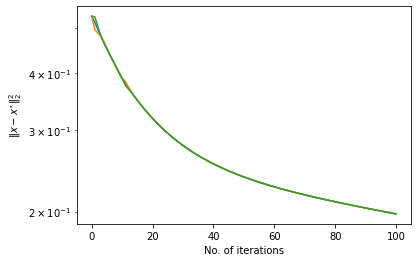

In [151]:
# convergence error
conv_error = np.zeros((tot_n_iter + 1,))

X_dis_cv = sol_var['X'].reshape((n_state, -1), order='F')[:n_targ_state, :]
X_dis_cv = X_dis_cv.reshape((-1, N, tot_n_iter + 1), order='F')

X_ncp_cv = X_ncp[:n_targ_state, :].reshape((-1, 1), order='F')
X_ncp_cv = np.broadcast_to(X_ncp_cv[..., None], (n_targ_state * T, N, tot_n_iter + 1))

# l2-norm
conv_error = np.sum((X_dis_cv - X_ncp_cv) ** 2.0, axis=0).T

# plot convergence error
iter_plot = range(0, conv_error.shape[0])

fig = plt.figure()

ax = plt.gca()

ln_cv = ax.plot(iter_plot, conv_error)

# axis labels
ax.set_xlabel('No. of iterations')
ax.set_ylabel('$\Vert x - x^{\star}\Vert_{2}^{2}$')

ax.set_yscale('log')

plt.show()

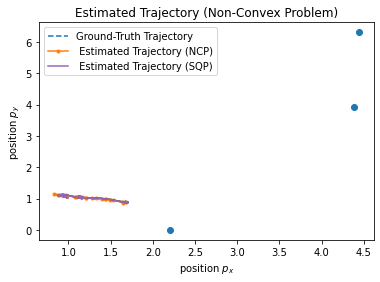

In [152]:
# iteration to plot
iter_p = sol_var['X'].shape[-1] - 1

# plot estimated trajectory
fig = plt.figure()
ax = plt.gca()

# ground-truth trajectory
l_gt, = ax.plot(X_true[0, :], X_true[1, :], '--')

# estimated trajectory via non-convex problem
l_ncp, = ax.plot(X_ncp[0, :], X_ncp[1, :], '.-')

# estimated trajectory via SQP
l_dis = ax.plot(sol_var['X'][0::n_state, :, iter_p], sol_var['X'][1::n_state, :, iter_p])

# sensors
l_sn = ax.scatter(agents_pos[0, :], agents_pos[1, :])

# axis labels
ax.set_xlabel('position $p_{x}$')
ax.set_ylabel('position $p_{y}$')

# legend
legend_label = ['Ground-Truth Trajectory',
                ' Estimated Trajectory (NCP)',
                ' Estimated Trajectory (SQP)']

ax.legend([l_gt, l_ncp, l_dis[-1]], legend_label)

title = ax.set_title('Estimated Trajectory (Non-Convex Problem)')